Lab 3

Task:
1. Write a program for planning a path from the initial point to the final point bypassing obstacles using the potential field method.
2. Independently determine the initial point of movement, the final point, and obstacles in the workspace.
3. The program code must reflect all the steps for constructing the potential field of the workspace, the order of calculating the gradient, and determining the subsequent direction of movement.
4. Illustrate achieved results.

In [68]:
import numpy as np
import roboticstoolbox as rtb
from roboticstoolbox import tools as rtb_tools
import matplotlib.pyplot as plt
from math import pi
from spatialmath import SE3

1. Initialization of the Puma 560 robot

In [69]:

robot = rtb.models.DH.Puma560()

2. Setting the initial and final configurations

In [70]:

q_start = np.array([0, 0, 0, 0, 0, 0])
q_goal = np.array([pi/4, -pi/3, -pi/4, pi/3, -pi/3, pi/4], dtype=np.float64)
q_goal_pos = robot.fkine(q_goal).t 

In [71]:
# Starting point (on the left)
T_start = SE3(0.6, -0.4, 0.3)  # X=-0.4, Y=0, Z=0.3

# The end point (on the right)
T_goal = SE3(-0.8, 0.4, 0.6)    # X=+0.4, Y=0, Z=0.3

q_start = robot.ikine_LM(T_start).q
q_goal = robot.ikine_LM(T_goal).q
q_goal_pos = robot.fkine(q_goal).t

3. Identifying obstacles in the workspace

In [72]:
obstacles = [
    {'pos': [0.4, 0.2, 0.3], 'radius': 0.15},
    {'pos': [0.1, -0.3, 0.2], 'radius': 0.1},
    {'pos': [-0.2, 0.1, 0.4], 'radius': 0.12}
]

4. Potential Field Parameters

In [73]:

eta_att = 0.5  # Coefficient of attraction
eta_rep = 0.8  # Coefficient of repulsion
rho_0 = 0.25   # Radius of influence of obstacles

def compute_potential(q):
    # Direct kinematics for the current configuration
    Te = robot.fkine(q)
    current_pos = Te.t
    
    # Attractive potential
    dist_to_goal = np.linalg.norm(current_pos - q_goal_pos)
    U_att = 0.5 * eta_att * dist_to_goal**2
    
    # Repulsive potential
    U_rep = 0
    for link in robot.links:
        T_link = robot.fkine(q, end=link.name)
        pos_link = T_link.t
        for obs in obstacles:
            dist = np.linalg.norm(pos_link - obs['pos'])
            if dist < obs['radius']:
                U_rep += 0.5 * eta_rep * (1/dist - 1/obs['radius'])**2
            elif dist < obs['radius'] + rho_0:
                U_rep += 0.5 * eta_rep * ((1/dist - 1/(obs['radius'] + rho_0))**2)
    
    return U_att + U_rep

5. Numerical calculation of the gradient

In [74]:
def compute_gradient(q, delta=1e-4):
    grad = np.zeros_like(q)
    for i in range(len(q)):
        q_plus = q.copy()
        q_plus[i] += delta
        q_minus = q.copy()
        q_minus[i] -= delta
        grad[i] = (compute_potential(q_plus) - compute_potential(q_minus)) / (2*delta)
    return grad

6. Path planning

In [75]:

current_q = q_start.copy().astype(np.float64)  # We guarantee float64
path = [current_q.copy()]
max_iter = 2000
step_size = 0.01

for _ in range(max_iter):
    grad = compute_gradient(current_q)
    norm_grad = np.linalg.norm(grad)
    # If the gradient is small, add a random perturbation
    if norm_grad < 1e-3:
        grad += np.random.uniform(-0.05, 0.05, size=grad.shape)
    current_q = current_q - step_size * grad
    path.append(current_q.copy())
    if np.linalg.norm(current_q - q_goal) < 0.01:
        break

7. Visualization of results

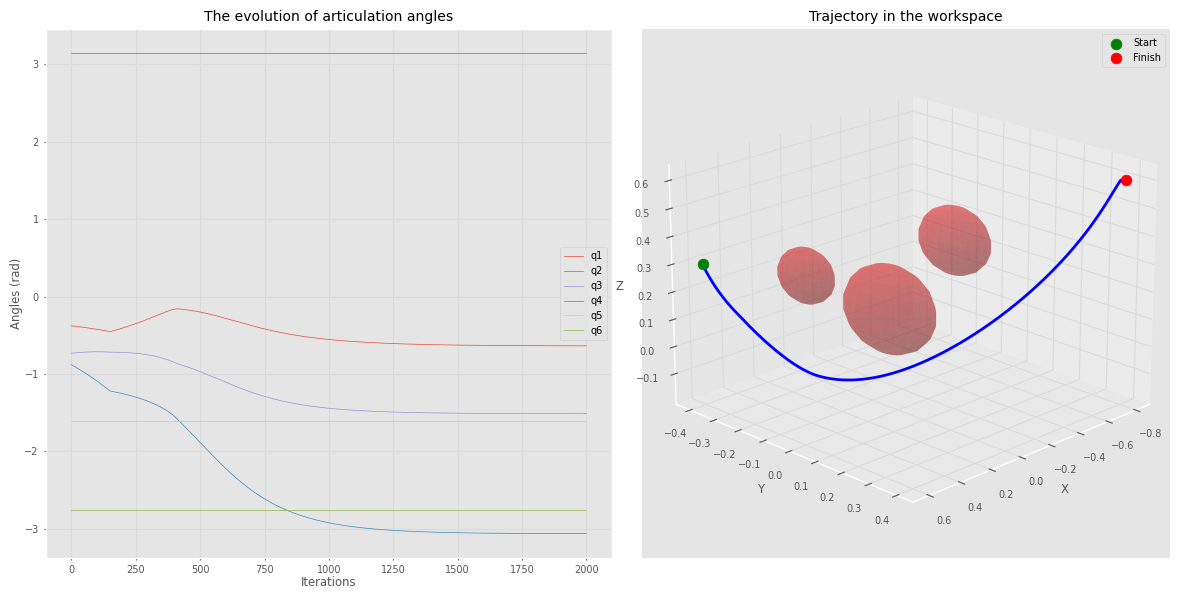

In [77]:
fig = plt.figure(figsize=(12, 6))

# Graph in the configuration space
ax1 = fig.add_subplot(121)
ax1.plot(np.array(path))
ax1.set_title('The evolution of articulation angles')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Angles (rad)')
ax1.legend([f'q{i+1}' for i in range(6)])
ax1.grid(True)

# 3D visualization of the trajectory
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Trajectory in the workspace')

# Displaying obstacles
for obs in obstacles:
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = obs['radius']*np.cos(u)*np.sin(v) + obs['pos'][0]
    y = obs['radius']*np.sin(u)*np.sin(v) + obs['pos'][1]
    z = obs['radius']*np.cos(v) + obs['pos'][2]
    ax2.plot_surface(x, y, z, color='red', alpha=0.3)

# The trajectory of the end effector
ee_path = [robot.fkine(q).t for q in path]
ee_path = np.array(ee_path)
ax2.plot(ee_path[:,0], ee_path[:,1], ee_path[:,2], 'b', linewidth=2)
# Start point (green)
ax2.scatter(T_start.t[0], T_start.t[1], T_start.t[2], color='green', s=60, label='Start')
# End point (red)
ax2.scatter(T_goal.t[0], T_goal.t[1], T_goal.t[2], color='red', s=60, label='Finish')

ax2.legend()

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()